In [1]:
import lightning as L
import numpy as np
import torch
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.unet import UNet
from minerva.models.nets.setr import SETR_PUP
from minerva.transforms.transform import _Transform
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
from matplotlib import pyplot as plt

In [2]:
class Padding(_Transform):
    def __init__(self, target_h_size: int, target_w_size: int):
        self.target_h_size = target_h_size
        self.target_w_size = target_w_size

    def __call__(self, x: np.ndarray) -> np.ndarray:
        h, w = x.shape[:2]
        pad_h = max(0, self.target_h_size - h)
        pad_w = max(0, self.target_w_size - w)
        if len(x.shape) == 2:
            padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
            padded = np.expand_dims(padded, axis=2)
            padded = torch.from_numpy(padded).float()
        else:
            padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
            padded = torch.from_numpy(padded).float()

        padded = np.transpose(padded, (2, 0, 1))
        return padded


transform = Padding(256, 704)

In [3]:
train_att_reader = TiffReader("f3/images/train")
val_att_reader = TiffReader("f3/images/val")
test_att_reader = TiffReader("f3/images/test")

train_lbl_reader = PNGReader("f3/annotations/train")
val_lbl_reader = PNGReader("f3/annotations/val")
test_lbl_reader = PNGReader("f3/annotations/test")

train_dataset = SupervisedReconstructionDataset(
    [train_att_reader, train_lbl_reader], transform
)
val_dataset = SupervisedReconstructionDataset(
    [val_att_reader, val_lbl_reader], transform
)
test_dataset = SupervisedReconstructionDataset(
    [test_att_reader, test_lbl_reader], transform
)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:
class F3DataModule(L.LightningDataModule):
    def __init__(self, train_dataloader, val_dataloader, test_dataloader):
        super().__init__()
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader

    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl


data_module = F3DataModule(train_dataloader, val_dataloader, test_dataloader)

In [5]:
model = SETR_PUP(
    image_size=(256, 704),
    num_classes=6,
    train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
)

In [6]:
trainer = L.Trainer(max_epochs=5)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | model   | _SetR_PUP        | 320 M 
---------------------------------------------
320 M     Trainable params
0         Non-trainable params
320 M     Total params
1,281.382 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\gabre\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\gabre\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(
C:\Users\gabre\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [7]:
trainer.test(model, data_module.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\gabre\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mIoU         │    0.3746854364871979     │
└───────────────────────────┴───────────────────────────┘

[{'test_mIoU': 0.3746854364871979}]

In [8]:
preds = trainer.predict(model, data_module.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\gabre\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [21]:
image = torch.argmax(preds[108], dim=1)


In [25]:
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

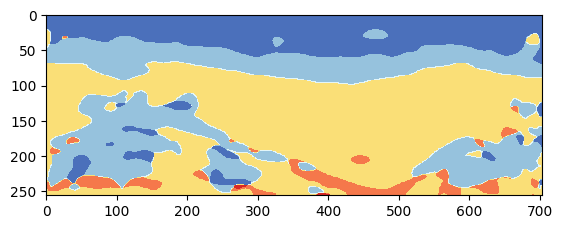

In [26]:
plt.imshow(image.squeeze().numpy(), cmap=label_cmap)
plt.show()